In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# from google.colab import drive
import PIL
# from PIL import Image

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard

%matplotlib inline

In [2]:
tf.__version__

'2.7.0'

In [3]:
# tf.debugging.set_log_device_placement(True)
# tf.debugging.get_log_device_placement()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
Num CPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# drive = drive.mount('/content/drive') 

In [5]:
# train_x_loc = "/content/drive/MyDrive/fdl/data/train_images/"
# train_y_loc = "/content/drive/MyDrive/fdl/data/train_masks/"

train_x_loc = "/Users/rishikeshavanrengarajan/tools/git/harvey-image-segmentation/data/train_images/"
train_y_loc = "/Users/rishikeshavanrengarajan/tools/git/harvey-image-segmentation/data/train_masks/"

In [6]:
img_names = sorted([s[:-4] for s in os.listdir(train_x_loc)])

In [7]:
INPUT_SIZE = 512
N_CHANNEL = 3
N_CLASSES = 27
BATCH_SIZE = 20

In [8]:
len(img_names)

261

In [28]:
# ids -> img_names
def batch_generator(ids, batch_size = BATCH_SIZE):
    batch=[]
    l = len(ids)
    s = 1
    while True:
        np.random.shuffle(ids) 
        for i in ids:
            batch.append(i)
            s += 1
            if len(batch)==batch_size or s == l:
                yield load_data(batch)
                batch=[]

def load_data(ids):
    X = []
    Y = []

    for i in ids:
        # read one or more samples from your storage, do pre-processing, etc.
        # for example:
        x = np.array(PIL.Image.open(train_x_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
        y = to_categorical(np.array(PIL.Image.open(train_y_loc + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)), N_CLASSES)

        X.append(x)
        Y.append(y)

    return np.array(X), np.array(Y)

In [11]:
gen = batch_generator(img_names)

In [12]:
print(gen)

<generator object batch_generator at 0x158bde900>


In [9]:
# del train_x
# del train_y

# train_x = []
# train_y = []
# for i in img_names:
#     train_x.append(np.array(PIL.Image.open(train_x_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255)
#     train_y.append(to_categorical(np.array(PIL.Image.open(train_y_loc + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)), 27))

In [10]:
# print(len(train_x))
# print(train_x[0].shape)
# print(len(train_y))
# print(train_y[0].shape)

261
(512, 512, 3)
261
(512, 512, 27)


In [14]:
def get_unet(lr=0.01):
#     inputs = Input((INPUT_SIZE_H, INPUT_SIZE_W, N_CHANNEL))
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = (pool1) # Dropout(0.2)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = (pool2) #Dropout(0.2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = (pool3) 

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = (pool4) # Dropout(0.2)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1))(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])
    
    # In semantic segmentation, you need as many masks as you have object classes. 
    # In our dataset, each pixel in every mask has been assigned a single integer probability that it belongs to a 
    # certain class - 0 to 24. The correct class is the layer with the higher probability. 

    # Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with 
    # lots of classes and to perform pixel-wise multiclass prediction. 
    model.compile(optimizer=Adam(learning_rate=lr), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])
    
#     unet.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[dice_coef])

    return model

In [29]:
unet = get_unet()

In [27]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 512, 512, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 512, 512, 32  9248        ['conv2d_38[0][0]']              
                                )                                                           

In [16]:
import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_batch_begin(self, batch, logs=None):
    print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_begin(self, batch, logs=None):
    print('Evaluating: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_end(self, batch, logs=None):
    print('Evaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

In [17]:
EPOCHS = 50
# VAL_SUBSPLITS = 5
# BUFFER_SIZE = 150
# BATCH_SIZE = 32

In [18]:
# dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

In [19]:
# train_dataset = dataset.batch(BATCH_SIZE)

In [20]:
# for i, m in dataset.take(1):
#     print(i.shape)
#     print(m.shape)

In [21]:
# del dataset

In [22]:
# del train_x
# del train_y

In [24]:
# tf.debugging.set_log_device_placement(False)
# tf.debugging.get_log_device_placement()
# print(type(train_x))

In [25]:
# Batch normalisation
# Change output layer; Sigmoid, softmax

In [30]:
train_generator = batch_generator(img_names, batch_size = BATCH_SIZE)

In [31]:
model_history = unet.fit(train_generator, epochs=EPOCHS,steps_per_epoch=14, callbacks=[MyCustomCallback()])

Epoch 1/50
Training: batch 0 begins at 05:08:36.971651


2022-01-04 05:08:37.254445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training: batch 0 ends at 05:08:44.086804
 1/14 [=>............................] - ETA: 1:32 - loss: 3.3344 - accuracy: 0.0196Training: batch 1 begins at 05:08:44.120441
Training: batch 1 ends at 05:08:50.154624
 2/14 [===>..........................] - ETA: 1:12 - loss: 15646.6797 - accuracy: 0.1090Training: batch 2 begins at 05:08:50.155608
Training: batch 2 ends at 05:08:56.068257
 3/14 [=====>........................] - ETA: 1:05 - loss: 10481.8896 - accuracy: 0.1205Training: batch 3 begins at 05:08:56.073695
Training: batch 3 ends at 05:09:01.959628
 4/14 [=======>......................] - ETA: 59s - loss: 8161.2188 - accuracy: 0.1273  Training: batch 4 begins at 05:09:01.970681
Training: batch 4 ends at 05:09:08.025704
 5/14 [=========>....................] - ETA: 53s - loss: 6610.7969 - accuracy: 0.1233Training: batch 5 begins at 05:09:08.029844
Training: batch 5 ends at 05:09:13.987697
 6/14 [===========>..................] - ETA: 47s - loss: 5512.5063 - accuracy: 0.1167Training

 6/14 [===========>..................] - ETA: 47s - loss: 2.9057 - accuracy: 0.2852Training: batch 6 begins at 05:13:23.969680
Training: batch 6 ends at 05:13:29.893003
 7/14 [==============>...............] - ETA: 41s - loss: 2.9013 - accuracy: 0.2817Training: batch 7 begins at 05:13:29.895910
Training: batch 7 ends at 05:13:35.645031
 8/14 [================>.............] - ETA: 35s - loss: 2.8963 - accuracy: 0.2897Training: batch 8 begins at 05:13:35.647672
Training: batch 8 ends at 05:13:41.388426
 9/14 [==================>...........] - ETA: 29s - loss: 2.8904 - accuracy: 0.2951Training: batch 9 begins at 05:13:41.389596
Training: batch 9 ends at 05:13:47.255809
10/14 [====================>.........] - ETA: 23s - loss: 2.8868 - accuracy: 0.2882Training: batch 10 begins at 05:13:47.259422
Training: batch 10 ends at 05:13:53.118258
11/14 [======================>.......] - ETA: 17s - loss: 2.8811 - accuracy: 0.2876Training: batch 11 begins at 05:13:53.120848
Training: batch 11 ends a

12/14 [========================>.....] - ETA: 11s - loss: 2.5700 - accuracy: 0.2838Training: batch 12 begins at 05:18:07.157498
Training: batch 12 ends at 05:18:13.066580
13/14 [==========================>...] - ETA: 5s - loss: 2.5707 - accuracy: 0.2786 Training: batch 13 begins at 05:18:13.071009
Training: batch 13 ends at 05:18:18.883243
14/14 [==============================] - 82s 6s/step - loss: 2.5654 - accuracy: 0.2795
Epoch 8/50
Training: batch 0 begins at 05:18:18.887804
Training: batch 0 ends at 05:18:24.913232
 1/14 [=>............................] - ETA: 1:18 - loss: 2.5824 - accuracy: 0.2920Training: batch 1 begins at 05:18:24.914214
Training: batch 1 ends at 05:18:30.931616
 2/14 [===>..........................] - ETA: 1:12 - loss: 2.5445 - accuracy: 0.2674Training: batch 2 begins at 05:18:30.935239
Training: batch 2 ends at 05:18:36.871915
 3/14 [=====>........................] - ETA: 1:05 - loss: 2.5322 - accuracy: 0.2975Training: batch 3 begins at 05:18:36.874203
Traini

 4/14 [=======>......................] - ETA: 59s - loss: 2.3077 - accuracy: 0.2938 Training: batch 4 begins at 05:22:50.465803
Training: batch 4 ends at 05:22:56.462542
 5/14 [=========>....................] - ETA: 53s - loss: 2.3011 - accuracy: 0.2908Training: batch 5 begins at 05:22:56.466133
Training: batch 5 ends at 05:23:02.264147
 6/14 [===========>..................] - ETA: 47s - loss: 2.3090 - accuracy: 0.2916Training: batch 6 begins at 05:23:02.271745
Training: batch 6 ends at 05:23:08.326116
 7/14 [==============>...............] - ETA: 41s - loss: 2.3102 - accuracy: 0.2911Training: batch 7 begins at 05:23:08.330660
Training: batch 7 ends at 05:23:14.323485
 8/14 [================>.............] - ETA: 35s - loss: 2.3119 - accuracy: 0.2922Training: batch 8 begins at 05:23:14.324600
Training: batch 8 ends at 05:23:20.228905
 9/14 [==================>...........] - ETA: 29s - loss: 2.3103 - accuracy: 0.2934Training: batch 9 begins at 05:23:20.232937
Training: batch 9 ends at 0

10/14 [====================>.........] - ETA: 23s - loss: 2.2289 - accuracy: 0.2948Training: batch 10 begins at 05:27:34.009327
Training: batch 10 ends at 05:27:39.880231
11/14 [======================>.......] - ETA: 17s - loss: 2.2291 - accuracy: 0.2877Training: batch 11 begins at 05:27:39.884914
Training: batch 11 ends at 05:27:45.971609
12/14 [========================>.....] - ETA: 11s - loss: 2.2264 - accuracy: 0.2871Training: batch 12 begins at 05:27:45.989836
Training: batch 12 ends at 05:27:52.003722
13/14 [==========================>...] - ETA: 5s - loss: 2.2279 - accuracy: 0.2854 Training: batch 13 begins at 05:27:52.008469
Training: batch 13 ends at 05:27:57.959926
14/14 [==============================] - 83s 6s/step - loss: 2.2308 - accuracy: 0.2821
Epoch 15/50
Training: batch 0 begins at 05:27:57.978820
Training: batch 0 ends at 05:28:03.842162
 1/14 [=>............................] - ETA: 1:16 - loss: 2.1722 - accuracy: 0.3395Training: batch 1 begins at 05:28:03.843799
Tra

 2/14 [===>..........................] - ETA: 1:12 - loss: 2.1376 - accuracy: 0.2889Training: batch 2 begins at 05:32:18.901887
Training: batch 2 ends at 05:32:24.872301
 3/14 [=====>........................] - ETA: 1:05 - loss: 2.1690 - accuracy: 0.2663Training: batch 3 begins at 05:32:24.896807
Training: batch 3 ends at 05:32:31.017123
 4/14 [=======>......................] - ETA: 1:00 - loss: 2.1679 - accuracy: 0.2684Training: batch 4 begins at 05:32:31.021632
Training: batch 4 ends at 05:32:37.017521
 5/14 [=========>....................] - ETA: 54s - loss: 2.1733 - accuracy: 0.2677 Training: batch 5 begins at 05:32:37.019322
Training: batch 5 ends at 05:32:42.974298
 6/14 [===========>..................] - ETA: 48s - loss: 2.1777 - accuracy: 0.2652Training: batch 6 begins at 05:32:42.976186
Training: batch 6 ends at 05:32:48.875572
 7/14 [==============>...............] - ETA: 41s - loss: 2.1764 - accuracy: 0.2674Training: batch 7 begins at 05:32:48.876589
Training: batch 7 ends a

 8/14 [================>.............] - ETA: 35s - loss: 2.1233 - accuracy: 0.2888Training: batch 8 begins at 05:37:12.216842
Training: batch 8 ends at 05:37:18.235773
 9/14 [==================>...........] - ETA: 29s - loss: 2.1201 - accuracy: 0.2935Training: batch 9 begins at 05:37:18.237545
Training: batch 9 ends at 05:37:24.292066
10/14 [====================>.........] - ETA: 23s - loss: 2.1146 - accuracy: 0.2930Training: batch 10 begins at 05:37:24.296039
Training: batch 10 ends at 05:37:30.242926
11/14 [======================>.......] - ETA: 17s - loss: 2.1171 - accuracy: 0.2933Training: batch 11 begins at 05:37:30.244931
Training: batch 11 ends at 05:37:36.231241
12/14 [========================>.....] - ETA: 11s - loss: 2.1197 - accuracy: 0.2908Training: batch 12 begins at 05:37:36.233146
Training: batch 12 ends at 05:37:42.178872
13/14 [==========================>...] - ETA: 5s - loss: 2.1216 - accuracy: 0.2868 Training: batch 13 begins at 05:37:42.182701
Training: batch 13 en

14/14 [==============================] - 83s 6s/step - loss: 2.0974 - accuracy: 0.2832
Epoch 25/50
Training: batch 0 begins at 05:41:58.966875
Training: batch 0 ends at 05:42:05.015741
 1/14 [=>............................] - ETA: 1:18 - loss: 2.1367 - accuracy: 0.3114Training: batch 1 begins at 05:42:05.023943
Training: batch 1 ends at 05:42:10.926723
 2/14 [===>..........................] - ETA: 1:10 - loss: 2.1345 - accuracy: 0.3121Training: batch 2 begins at 05:42:10.929270
Training: batch 2 ends at 05:42:17.004620
 3/14 [=====>........................] - ETA: 1:05 - loss: 2.1466 - accuracy: 0.3067Training: batch 3 begins at 05:42:17.009218
Training: batch 3 ends at 05:42:22.978888
 4/14 [=======>......................] - ETA: 59s - loss: 2.1374 - accuracy: 0.2930 Training: batch 4 begins at 05:42:22.983438
Training: batch 4 ends at 05:42:28.973248
 5/14 [=========>....................] - ETA: 53s - loss: 2.1482 - accuracy: 0.2836Training: batch 5 begins at 05:42:28.975299
Training

 6/14 [===========>..................] - ETA: 47s - loss: 2.0870 - accuracy: 0.2776Training: batch 6 begins at 05:46:46.059453
Training: batch 6 ends at 05:46:52.053127
 7/14 [==============>...............] - ETA: 41s - loss: 2.0935 - accuracy: 0.2810Training: batch 7 begins at 05:46:52.054193
Training: batch 7 ends at 05:46:58.063416
 8/14 [================>.............] - ETA: 35s - loss: 2.1002 - accuracy: 0.2814Training: batch 8 begins at 05:46:58.065391
Training: batch 8 ends at 05:47:04.048775
 9/14 [==================>...........] - ETA: 29s - loss: 2.0982 - accuracy: 0.2828Training: batch 9 begins at 05:47:04.052365
Training: batch 9 ends at 05:47:09.945693
10/14 [====================>.........] - ETA: 23s - loss: 2.0992 - accuracy: 0.2846Training: batch 10 begins at 05:47:09.947341
Training: batch 10 ends at 05:47:16.086336
11/14 [======================>.......] - ETA: 17s - loss: 2.0946 - accuracy: 0.2848Training: batch 11 begins at 05:47:16.088471
Training: batch 11 ends a

12/14 [========================>.....] - ETA: 11s - loss: 2.0725 - accuracy: 0.2946Training: batch 12 begins at 05:51:34.389406
Training: batch 12 ends at 05:51:40.355884
13/14 [==========================>...] - ETA: 5s - loss: 2.0674 - accuracy: 0.2971 Training: batch 13 begins at 05:51:40.357223
Training: batch 13 ends at 05:51:46.399215
14/14 [==============================] - 84s 6s/step - loss: 2.0647 - accuracy: 0.2975
Epoch 32/50
Training: batch 0 begins at 05:51:46.414994
Training: batch 0 ends at 05:51:52.299348
 1/14 [=>............................] - ETA: 1:16 - loss: 2.0715 - accuracy: 0.2977Training: batch 1 begins at 05:51:52.300797
Training: batch 1 ends at 05:51:58.264594
 2/14 [===>..........................] - ETA: 1:11 - loss: 2.0950 - accuracy: 0.2733Training: batch 2 begins at 05:51:58.271677
Training: batch 2 ends at 05:52:04.320747
 3/14 [=====>........................] - ETA: 1:06 - loss: 2.1134 - accuracy: 0.2577Training: batch 3 begins at 05:52:04.324976
Train

 4/14 [=======>......................] - ETA: 59s - loss: 2.0843 - accuracy: 0.2589 Training: batch 4 begins at 05:56:22.416854
Training: batch 4 ends at 05:56:28.566887
 5/14 [=========>....................] - ETA: 54s - loss: 2.0989 - accuracy: 0.2599Training: batch 5 begins at 05:56:28.571597
Training: batch 5 ends at 05:56:34.587249
 6/14 [===========>..................] - ETA: 48s - loss: 2.0844 - accuracy: 0.2665Training: batch 6 begins at 05:56:34.591890
Training: batch 6 ends at 05:56:40.611256
 7/14 [==============>...............] - ETA: 42s - loss: 2.0814 - accuracy: 0.2781Training: batch 7 begins at 05:56:40.615469
Training: batch 7 ends at 05:56:46.627530
 8/14 [================>.............] - ETA: 36s - loss: 2.0702 - accuracy: 0.2800Training: batch 8 begins at 05:56:46.631647
Training: batch 8 ends at 05:56:52.655593
 9/14 [==================>...........] - ETA: 30s - loss: 2.0647 - accuracy: 0.2819Training: batch 9 begins at 05:56:52.659160
Training: batch 9 ends at 0

10/14 [====================>.........] - ETA: 23s - loss: 2.0905 - accuracy: 0.2755Training: batch 10 begins at 06:01:10.559944
Training: batch 10 ends at 06:01:16.594200
11/14 [======================>.......] - ETA: 17s - loss: 2.0842 - accuracy: 0.2760Training: batch 11 begins at 06:01:16.595840
Training: batch 11 ends at 06:01:22.604014
12/14 [========================>.....] - ETA: 11s - loss: 2.0770 - accuracy: 0.2774Training: batch 12 begins at 06:01:22.605730
Training: batch 12 ends at 06:01:28.582161
13/14 [==========================>...] - ETA: 5s - loss: 2.0677 - accuracy: 0.2782 Training: batch 13 begins at 06:01:28.593854
Training: batch 13 ends at 06:01:34.623064
14/14 [==============================] - 84s 6s/step - loss: 2.0667 - accuracy: 0.2859
Epoch 39/50
Training: batch 0 begins at 06:01:34.630024
Training: batch 0 ends at 06:01:40.632515
 1/14 [=>............................] - ETA: 1:18 - loss: 2.0217 - accuracy: 0.3023Training: batch 1 begins at 06:01:40.636308
Tra

 2/14 [===>..........................] - ETA: 1:09 - loss: 2.0787 - accuracy: 0.2744Training: batch 2 begins at 06:05:58.262976
Training: batch 2 ends at 06:06:04.170456
 3/14 [=====>........................] - ETA: 1:04 - loss: 2.0728 - accuracy: 0.3006Training: batch 3 begins at 06:06:04.174601
Training: batch 3 ends at 06:06:10.240287
 4/14 [=======>......................] - ETA: 59s - loss: 2.0717 - accuracy: 0.3017 Training: batch 4 begins at 06:06:10.244052
Training: batch 4 ends at 06:06:16.311560
 5/14 [=========>....................] - ETA: 53s - loss: 2.0754 - accuracy: 0.2894Training: batch 5 begins at 06:06:16.328036
Training: batch 5 ends at 06:06:22.369586
 6/14 [===========>..................] - ETA: 47s - loss: 2.0810 - accuracy: 0.2879Training: batch 6 begins at 06:06:22.374040
Training: batch 6 ends at 06:06:28.495217
 7/14 [==============>...............] - ETA: 42s - loss: 2.0635 - accuracy: 0.2967Training: batch 7 begins at 06:06:28.499413
Training: batch 7 ends at

 8/14 [================>.............] - ETA: 35s - loss: 2.0605 - accuracy: 0.2770Training: batch 8 begins at 06:10:45.683214
Training: batch 8 ends at 06:10:51.679523
 9/14 [==================>...........] - ETA: 29s - loss: 2.0540 - accuracy: 0.2806Training: batch 9 begins at 06:10:51.683460
Training: batch 9 ends at 06:10:57.602961
10/14 [====================>.........] - ETA: 23s - loss: 2.0679 - accuracy: 0.2781Training: batch 10 begins at 06:10:57.604660
Training: batch 10 ends at 06:11:03.650290
11/14 [======================>.......] - ETA: 17s - loss: 2.0604 - accuracy: 0.2835Training: batch 11 begins at 06:11:03.655227
Training: batch 11 ends at 06:11:09.685300
12/14 [========================>.....] - ETA: 11s - loss: 2.0629 - accuracy: 0.2847Training: batch 12 begins at 06:11:09.687168
Training: batch 12 ends at 06:11:15.717139
13/14 [==========================>...] - ETA: 5s - loss: 2.0640 - accuracy: 0.2831 Training: batch 13 begins at 06:11:15.729511
Training: batch 13 en

14/14 [==============================] - 84s 6s/step - loss: 2.0705 - accuracy: 0.2822
Epoch 49/50
Training: batch 0 begins at 06:15:33.217263
Training: batch 0 ends at 06:15:39.252211
 1/14 [=>............................] - ETA: 1:18 - loss: 2.0431 - accuracy: 0.2249Training: batch 1 begins at 06:15:39.256281
Training: batch 1 ends at 06:15:45.304857
 2/14 [===>..........................] - ETA: 1:12 - loss: 2.0187 - accuracy: 0.2840Training: batch 2 begins at 06:15:45.306654
Training: batch 2 ends at 06:15:51.354551
 3/14 [=====>........................] - ETA: 1:06 - loss: 2.0284 - accuracy: 0.2880Training: batch 3 begins at 06:15:51.358779
Training: batch 3 ends at 06:15:57.330035
 4/14 [=======>......................] - ETA: 1:00 - loss: 2.0403 - accuracy: 0.2846Training: batch 4 begins at 06:15:57.334485
Training: batch 4 ends at 06:16:03.387033
 5/14 [=========>....................] - ETA: 54s - loss: 2.0184 - accuracy: 0.2974 Training: batch 5 begins at 06:16:03.391825
Trainin

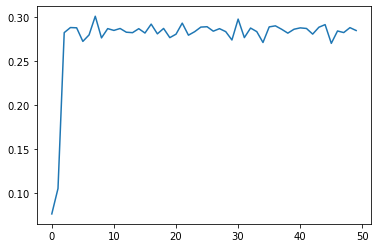

In [32]:

plt.plot(model_history.history["accuracy"])

In [33]:
training_iter = "training_6"
# checkpoint_path = "checkpoints/training_3/cp.ckpt"
save_weights_location = "saved_weights/"+ training_iter +"/"
save_model_location = "saved_models/"+ training_iter +"/"

# save the weights manually
unet.save_weights(save_weights_location)

# save the entire model as "SavedModel"
unet.save(save_model_location)
h5py_save_location = save_model_location + "my_model.h5"
unet.save(h5py_save_location)

2022-01-04 06:18:21.961908: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/training_6/assets


In [35]:
print(save_model_location)

saved_models/training_6/


INFO:tensorflow:Assets written to: saved_models/training_6/assets


(512, 512, 1)


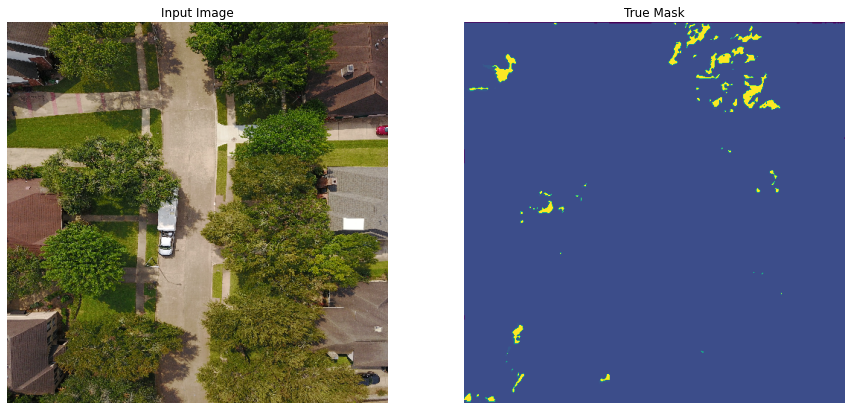

In [24]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
#     tf.keras.preprocessing.image.save_img(f'my_picture.png', pred_mask[0])
    print(pred_mask[0].shape)
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
        pred_mask = unet.predict(image)
        display([image[0], create_mask(pred_mask)])
show_predictions(train_dataset)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


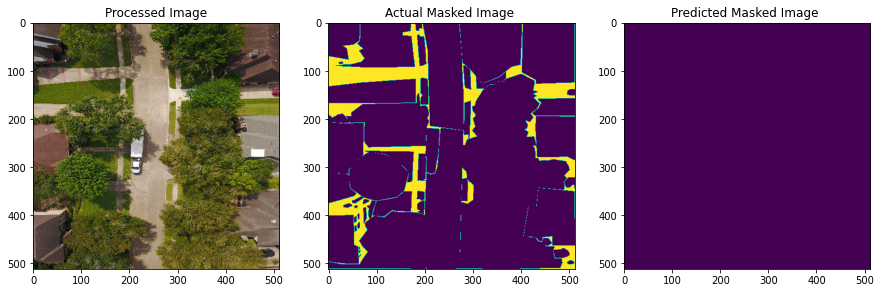

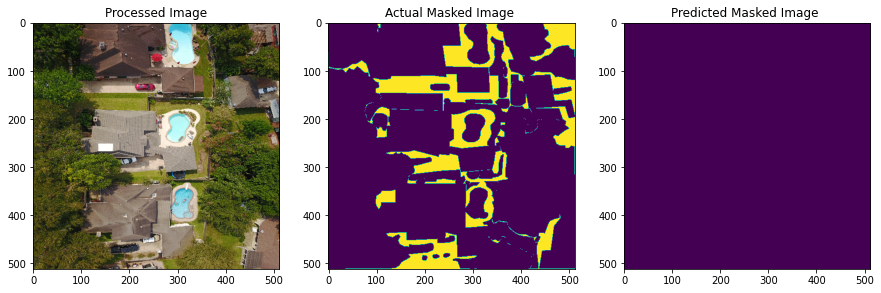

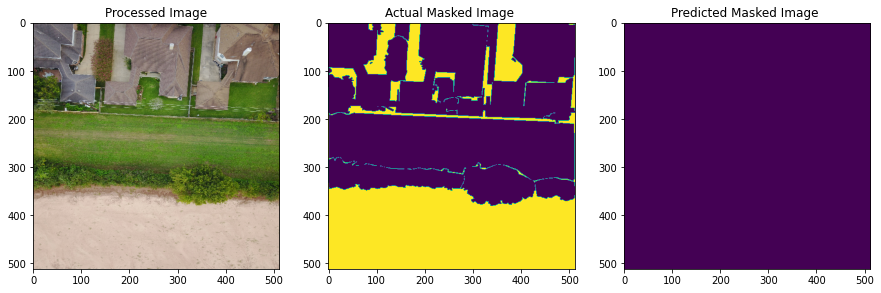

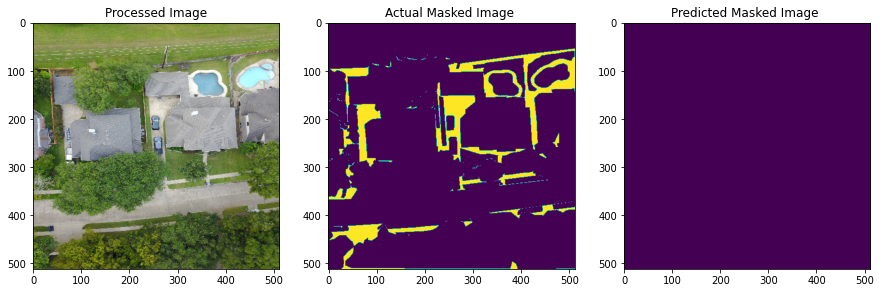

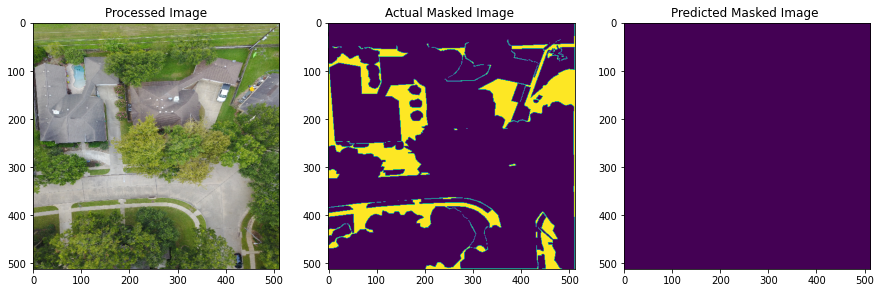

In [ ]:
def VisualizeResults():
    for i, m in dataset.take(5):
      img = i
      img = img[np.newaxis, ...]
      pred_y = unet.predict(img)
      print(type(pred_y))
      # create_rles(pred_y)
      pred_mask = tf.argmax(pred_y[0], axis=-1)
      pred_mask = pred_mask[..., tf.newaxis]
      fig, arr = plt.subplots(1, 3, figsize=(15, 15))

      arr[0].imshow(i)
      arr[0].set_title('Processed Image')
      arr[1].imshow(m[:,:,0])
      arr[1].set_title('Actual Masked Image ')
      arr[2].imshow(pred_mask[:,:,0])
      arr[2].set_title('Predicted Masked Image ')

VisualizeResults()

In [ ]:


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    # dir = '../data/test_preds/'
    # N = len(list(os.listdir(dir)))
    with open('submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        # for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))
        mask = Image.open("predd.png")
        mask = mask.resize((1024, 1024))
        mask = np.array(mask)

        for x in range(1, 25):
            enc = rle_encode(mask == x)
            f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()